## Imports

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Download Data

In [173]:
# Multi-asset ETFs
tickers = ['SPY', 'QQQ', 'IWM', 'VEA', 'VWO','MSFT']

# Download historical adjusted close prices
data = yf.download(tickers, start='2023-01-01', end='2025-06-21')['Close']

# Drop rows with any missing values
data = data.dropna()

data.to_csv("multi_asset_etf_data.csv")


/tmp/ipykernel_8943/642635479.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2023-01-01', end='2025-06-21')['Close']
[*********************100%***********************]  6 of 6 completed


In [174]:
data = pd.read_csv("multi_asset_etf_data.csv", index_col=0, parse_dates=True)


## Calculate Daily Returns

In [175]:
returns = data.pct_change().dropna()


In [185]:
returns.head()

,IWM,MSFT,QQQ,SPY,VEA,VWO
Date,,,,,,
2023-01-04,0.012457,-0.043743,0.004764,0.007720,0.014929,0.025888
2023-01-05,-0.010709,-0.029638,-0.015655,-0.011413,-0.011207,-0.002969
2023-01-06,0.022455,0.011785,0.027602,0.022932,0.027627,0.017122
2023-01-09,0.001689,0.009736,0.006473,-0.000567,0.004366,0.005367
2023-01-10,0.014785,0.007617,0.008465,0.007013,0.002517,0.007037


## Analytical Solution

In [186]:

def analytical_min_var_weights(cov_matrix):
    ones = np.ones(cov_matrix.shape[0])
    inv_cov = np.linalg.inv(cov_matrix.values)
    weights = inv_cov @ ones
    weights /= ones.T @ inv_cov @ ones
    return weights



## Walk Forward Implementation

In [178]:
lookback = 22*6
test_window =22

weights_list = []
port_returns = []

for start in range(0, len(returns) - lookback - test_window, test_window):
    train = returns.iloc[start : start + lookback]
    test = returns.iloc[start + lookback : start + lookback + test_window]
    
    cov = train.cov()
    weights = analytical_min_var_weights(cov)
    
    weights_list.append(weights)
    port_returns.append(test @ weights)


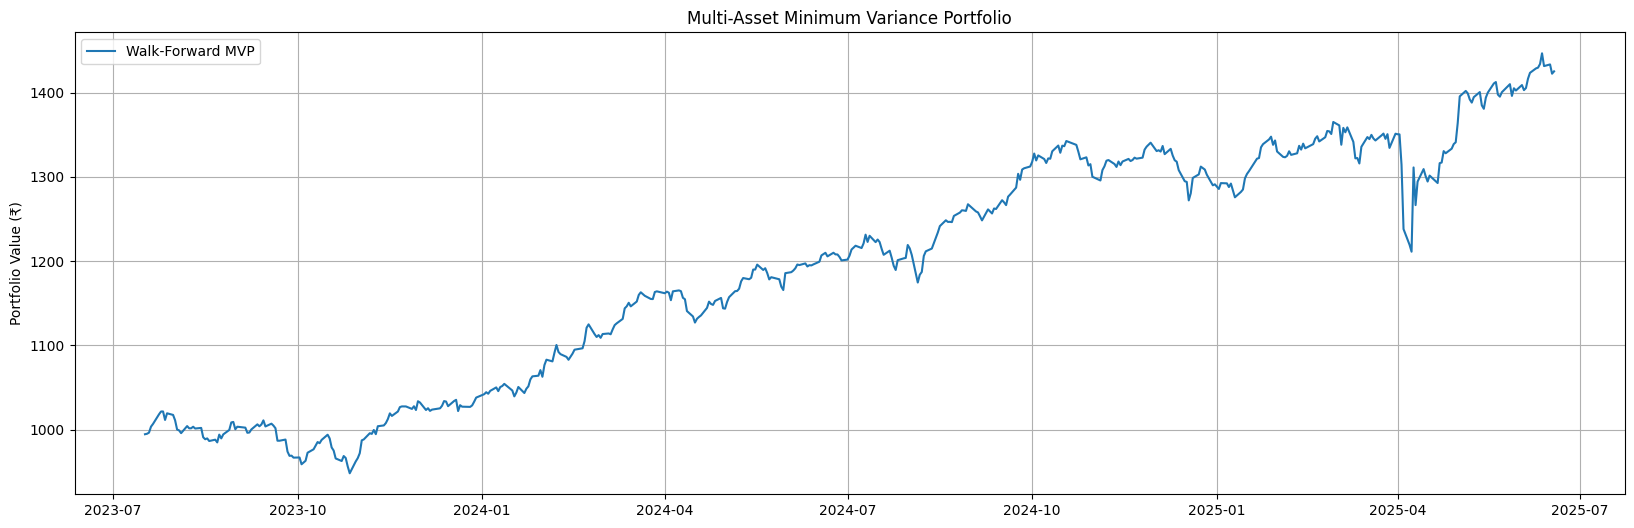

In [179]:
walkforward_returns = pd.concat(port_returns)
cumulative_returns = (1 + walkforward_returns).cumprod()
portfolio_value = cumulative_returns * 1000  # Starting capital ₹1000

# Plot
plt.figure(figsize=(20, 6))
plt.plot(portfolio_value, label="Walk-Forward MVP")
plt.title("Multi-Asset Minimum Variance Portfolio")
plt.ylabel("Portfolio Value (₹)")
plt.grid(True)
plt.legend()
plt.show()


## Equal Asset Portfolio

In [180]:
equal_returns = []

n_assets = returns.shape[1]
equal_weight = np.repeat(1/n_assets, n_assets)

for start in range(0, len(returns) - lookback - test_window, test_window):
    test = returns.iloc[start + lookback : start + lookback + test_window]
    equal_returns.append(test @ equal_weight)

equal_returns_all = pd.concat(equal_returns)
equal_cumulative = (1 + equal_returns_all).cumprod()


In [181]:
initial_capital = 1000
mvp_value = (1 + walkforward_returns).cumprod() * initial_capital
equal_value = (1 + equal_returns_all).cumprod() * initial_capital


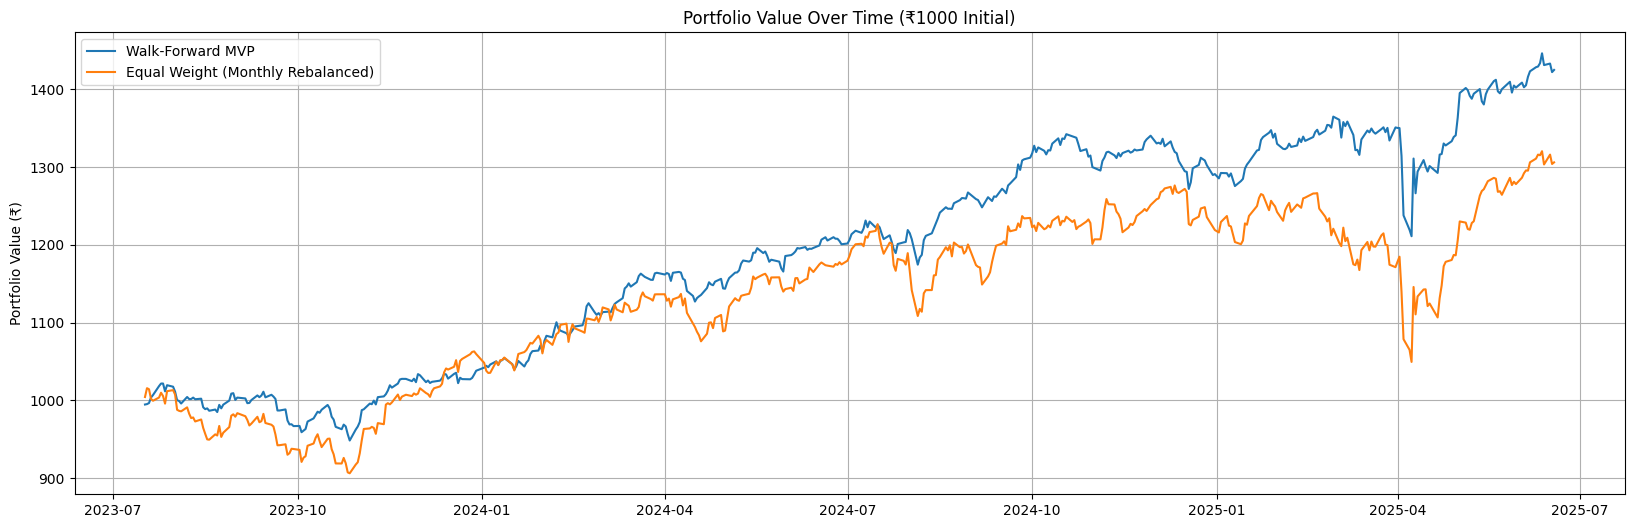

In [182]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(mvp_value, label="Walk-Forward MVP")
plt.plot(equal_value, label="Equal Weight (Monthly Rebalanced)")
plt.title("Portfolio Value Over Time (₹1000 Initial)")
plt.ylabel("Portfolio Value (₹)")
plt.grid(True)
plt.legend()
plt.show()


## Performance Metrics

In [184]:
def sharpe_ratio(returns, rf=0.06):
    excess = returns - rf / 252
    return (excess.mean() / excess.std()) * np.sqrt(252)

def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    drawdown = cum_returns / peak - 1
    return drawdown.min()

def annualized_return(returns):
    return (1 + returns.mean())**252 - 1

def annualized_volatility(returns):
    return returns.std() * np.sqrt(252)

def evaluate_strategy(name, returns):
    cum = (1 + returns).cumprod()
    print(f"\n{name}")
    print(f"{'-'*len(name)}")
    print(f"Sharpe Ratio       : {sharpe_ratio(returns):.2f}")
    print(f"Annual Return      : {annualized_return(returns):.2%}")
    print(f"Volatility         : {annualized_volatility(returns):.2%}")
    print(f"Max Drawdown       : {max_drawdown(cum):.2%}")

evaluate_strategy("Walk-Forward MVP", walkforward_returns)
evaluate_strategy("Equal Weight", equal_returns_all)



Walk-Forward MVP
----------------
Sharpe Ratio       : 1.05
Annual Return      : 21.20%
Volatility         : 12.56%
Max Drawdown       : -11.27%

Equal Weight
------------
Sharpe Ratio       : 0.57
Annual Return      : 16.45%
Volatility         : 16.32%
Max Drawdown       : -17.79%
